# Emotion Classifier

## Instalación de bibliotecas

In [37]:
# %pip install mediapipe
# %pip install imbalanced-learn

## Bibliotecas

In [38]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib

## Rutas de entrada

In [39]:
RUTA_BASE = "SAMMv3"
TAMAÑO_FINAL = 224

MAPEO_EMOCIONES = {
    "Anger": 0,
    "Contempt": 1,
    "Disgust": 2,
    "Fear": 3,
    "Happiness": 4,
    "Sadness": 5,
    "Surprise": 6
}

## Funciones

In [40]:
def cargar_imagen_segura(ruta):
    try:
        imagen = cv2.imread(ruta, cv2.IMREAD_REDUCED_GRAYSCALE_2)
        if imagen is None:
            return None
        for escala in [0.25, 0.1]:
            try:
                return cv2.resize(imagen, (0, 0), fx=escala, fy=escala)
            except:
                continue
        return None
    except:
        return None

def preprocesar_imagen(imagen):
    try:
        alto, ancho = imagen.shape[:2]
        lado = min(alto, ancho)
        y = (alto - lado) // 2
        x = (ancho - lado) // 2
        recorte = imagen[y:y+lado, x:x+lado]
        return cv2.resize(recorte, (TAMAÑO_FINAL, TAMAÑO_FINAL))
    except:
        return None

def extraer_landmarks(imagen, mallador):
    try:
        if len(imagen.shape) == 2:
            imagen = cv2.cvtColor(imagen, cv2.COLOR_GRAY2RGB)
        resultados = mallador.process(imagen)
        if resultados.multi_face_landmarks:
            return np.array([[p.x, p.y] for p in resultados.multi_face_landmarks[0].landmark])
    except:
        return None
    return None

def normalizar_landmarks(landmarks):
    try:
        centro = landmarks[1]
        landmarks -= centro
        escala = np.linalg.norm(landmarks[234] - landmarks[454])
        return (landmarks / escala).flatten()
    except:
        return None

## Carga de datos y balanceo de datos

In [41]:
def cargar_dataset():
    mp_face_mesh = mp.solutions.face_mesh
    mallador = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3)
    datos_por_clase = {}

    for emocion, codigo in MAPEO_EMOCIONES.items():
        carpeta = os.path.join(RUTA_BASE, emocion)
        if not os.path.exists(carpeta):
            print(f"¡Carpeta no encontrada! {carpeta}")
            continue

        archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total = len(archivos)
        if total == 0:
            continue
        if total > 900:
            archivos = archivos[:900]

        print(f"Procesando '{emocion}' ({len(archivos)} imágenes)...")
        X_tmp, y_tmp = [], []

        for archivo in tqdm(archivos, desc=f"Procesando {emocion}"):
            ruta = os.path.join(carpeta, archivo)
            img = cargar_imagen_segura(ruta)
            if img is not None:
                img_proc = preprocesar_imagen(img)
                if img_proc is not None:
                    landmarks = extraer_landmarks(img_proc, mallador)
                    if landmarks is not None:
                        norm = normalizar_landmarks(landmarks)
                        if norm is not None:
                            X_tmp.append(norm)
                            y_tmp.append(codigo)

        if len(X_tmp) < 800 and len(X_tmp) > 0:
            print(f"Aplicando SMOTE para '{emocion}' ({len(X_tmp)} → 800)...")
            X_tmp.append(np.zeros_like(X_tmp[0]))
            y_tmp.append(-1)
            smote = SMOTE(sampling_strategy={codigo: 800}, random_state=42)
            X_res, y_res = smote.fit_resample(X_tmp, y_tmp)
            X_tmp = [x for x, yv in zip(X_res, y_res) if yv == codigo]
            y_tmp = [codigo] * len(X_tmp)

        datos_por_clase[codigo] = (X_tmp, y_tmp)

    mallador.close()
    X, y = [], []
    for Xc, yc in datos_por_clase.values():
        X.extend(Xc)
        y.extend(yc)

    return np.array(X), np.array(y)

## Entrenar y evaluar

In [42]:
def entrenar_modelo(X, y):
    modelo = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')
    )
    modelo.fit(X, y)
    return modelo

## Obtener modelo entrenado y guardarlo en un pkl

In [43]:
# ejecucion
print("=== CARGANDO DATASET ===")
X, y = cargar_dataset()
print(f"\nTotal de muestras: {len(X)}\nDistribución final:", Counter(y))

print("\n=== VALIDACIÓN CRUZADA ===")
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced'))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')
print(f"Accuracy promedio: {acc_scores.mean():.4f}")
print(f"F1 macro promedio: {f1_scores.mean():.4f}")

print("\n=== ENTRENAMIENTO FINAL ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)
modelo = entrenar_modelo(X_train, y_train)

print("\n=== GUARDANDO MODELO ===")
joblib.dump(modelo, "modelo_emociones.pkl")
print("Modelo guardado como 'modelo_emociones.pkl'")

print("\n=== EVALUACIÓN ===")
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=MAPEO_EMOCIONES.keys()))

=== CARGANDO DATASET ===
Procesando 'Anger' (900 imágenes)...


Procesando Anger: 100%|██████████| 900/900 [00:08<00:00, 106.80it/s]


Procesando 'Contempt' (896 imágenes)...


Procesando Contempt: 100%|██████████| 896/896 [00:08<00:00, 108.42it/s]


Procesando 'Disgust' (666 imágenes)...


Procesando Disgust: 100%|██████████| 666/666 [00:06<00:00, 106.99it/s]


Aplicando SMOTE para 'Disgust' (666 → 800)...
Procesando 'Fear' (534 imágenes)...


Procesando Fear: 100%|██████████| 534/534 [00:04<00:00, 107.53it/s]


Aplicando SMOTE para 'Fear' (534 → 800)...
Procesando 'Happiness' (900 imágenes)...


Procesando Happiness: 100%|██████████| 900/900 [00:08<00:00, 106.78it/s]


Procesando 'Sadness' (391 imágenes)...


Procesando Sadness: 100%|██████████| 391/391 [00:03<00:00, 108.45it/s]


Aplicando SMOTE para 'Sadness' (391 → 800)...
Procesando 'Surprise' (900 imágenes)...


Procesando Surprise: 100%|██████████| 900/900 [00:08<00:00, 107.52it/s]



Total de muestras: 5996
Distribución final: Counter({np.int64(0): 900, np.int64(4): 900, np.int64(6): 900, np.int64(1): 896, np.int64(2): 800, np.int64(3): 800, np.int64(5): 800})

=== VALIDACIÓN CRUZADA ===
Accuracy promedio: 0.9923
F1 macro promedio: 0.9924

=== ENTRENAMIENTO FINAL ===

=== GUARDANDO MODELO ===
Modelo guardado como 'modelo_emociones.pkl'

=== EVALUACIÓN ===
              precision    recall  f1-score   support

       Anger       1.00      0.99      0.99       180
    Contempt       0.99      1.00      0.99       180
     Disgust       1.00      1.00      1.00       160
        Fear       1.00      1.00      1.00       160
   Happiness       1.00      1.00      1.00       180
     Sadness       0.97      1.00      0.98       160
    Surprise       0.99      0.96      0.97       180

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



## Visualización

In [44]:
modelo = joblib.load("modelo_emociones.pkl")
MAPEO_EMOCIONES_INV = {v: k for k, v in MAPEO_EMOCIONES.items()}

def cargar_imagen_segura(ruta):
    try:
        imagen = cv2.imread(ruta, cv2.IMREAD_REDUCED_GRAYSCALE_2)
        if imagen is None:
            return None
        for escala in [0.25, 0.1]:
            try:
                return cv2.resize(imagen, (0, 0), fx=escala, fy=escala)
            except:
                continue
        return None
    except:
        return None

def preprocesar_imagen(imagen):
    try:
        alto, ancho = imagen.shape[:2]
        lado = min(alto, ancho)
        y = (alto - lado) // 2
        x = (ancho - lado) // 2
        recorte = imagen[y:y+lado, x:x+lado]
        return cv2.resize(recorte, (224, 224))
    except:
        return None

def extraer_landmarks(imagen):
    try:
        mp_face_mesh = mp.solutions.face_mesh
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3) as mallador:
            if len(imagen.shape) == 2:
                imagen = cv2.cvtColor(imagen, cv2.COLOR_GRAY2RGB)
            resultados = mallador.process(imagen)
            if resultados.multi_face_landmarks:
                return np.array([[p.x, p.y] for p in resultados.multi_face_landmarks[0].landmark])
    except:
        return None
    return None

def normalizar_landmarks(landmarks):
    try:
        centro = landmarks[1]
        landmarks -= centro
        escala = np.linalg.norm(landmarks[234] - landmarks[454])
        return (landmarks / escala).flatten()
    except:
        return None

def predecir_emocion(ruta_imagen):
    # 1. Cargar imagen original sin procesar (color, tal cual está)
    img_original = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if img_original is None:
        print("No se pudo cargar la imagen original.")
        return

    # 2. Cargar versión reducida para procesamiento
    img = cargar_imagen_segura(ruta_imagen)  # esta sí puede ser reducida y en gris
    if img is None:
        print("No se pudo cargar la imagen para análisis.")
        return

    img_proc = preprocesar_imagen(img)
    if img_proc is None:
        print("No se pudo procesar la imagen.")
        return

    landmarks = extraer_landmarks(img_proc)
    if landmarks is None:
        print("No se detectaron landmarks.")
        return

    landmarks_visuales = landmarks.copy()
    norm_landmarks = normalizar_landmarks(landmarks)
    if norm_landmarks is None:
        print("No se pudo normalizar la imagen.")
        return

    pred = modelo.predict([norm_landmarks])[0]
    emocion = MAPEO_EMOCIONES_INV[pred]

    # 3. Imagen con landmarks
    img_color = cv2.cvtColor(img_proc.copy(), cv2.COLOR_GRAY2BGR)
    h, w = img_proc.shape[:2]

    for punto in landmarks_visuales:
        x = int(punto[0] * w)
        y = int(punto[1] * h)
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(img_color, (x, y), 2, (0, 255, 0), -1)

    # 4. Convertir para visualización con matplotlib
    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_con_landmarks = cv2.cvtColor(img_color.copy(), cv2.COLOR_BGR2RGB)

    # 5. Mostrar ambas imágenes
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original_rgb)
    plt.title("Original (sin procesar)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_con_landmarks)
    plt.title(f"Predicción: {emocion}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

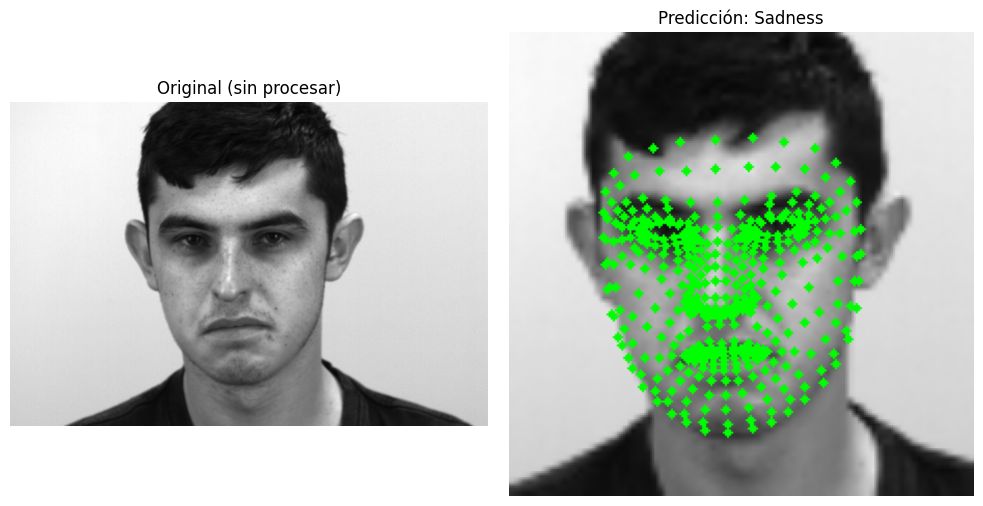

In [ ]:
# pruebas
predecir_emocion("pruebas/p1.jpg")

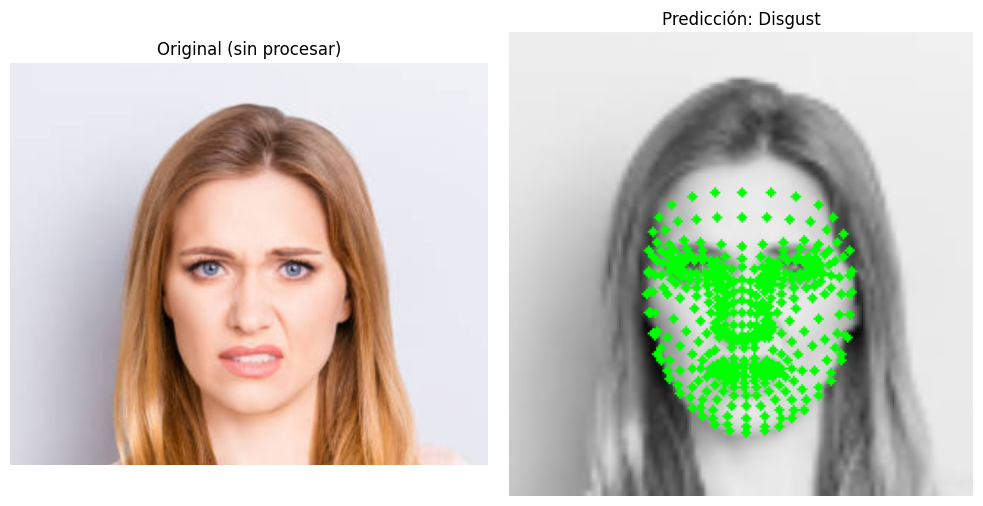

In [ ]:
predecir_emocion("pruebas/p2.jpg")

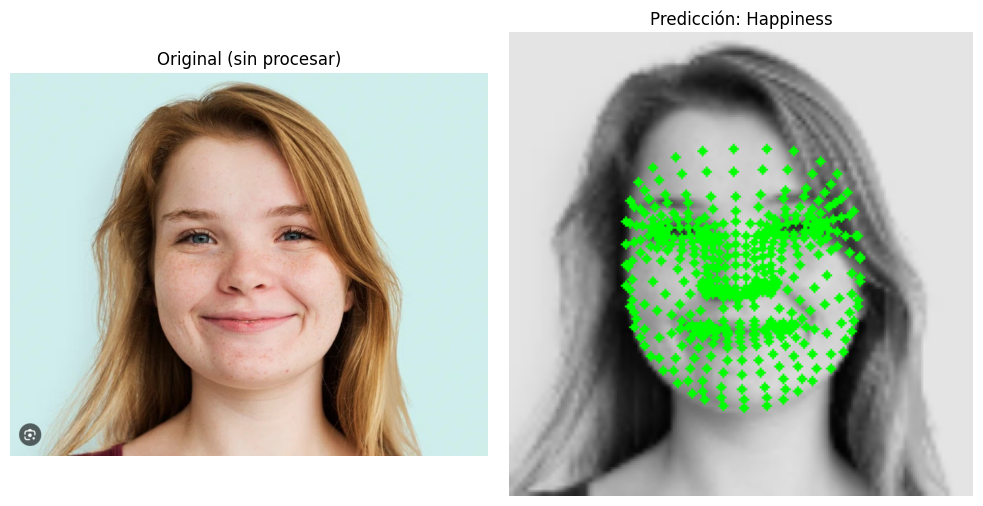

In [ ]:
predecir_emocion("pruebas/p3.jpg")

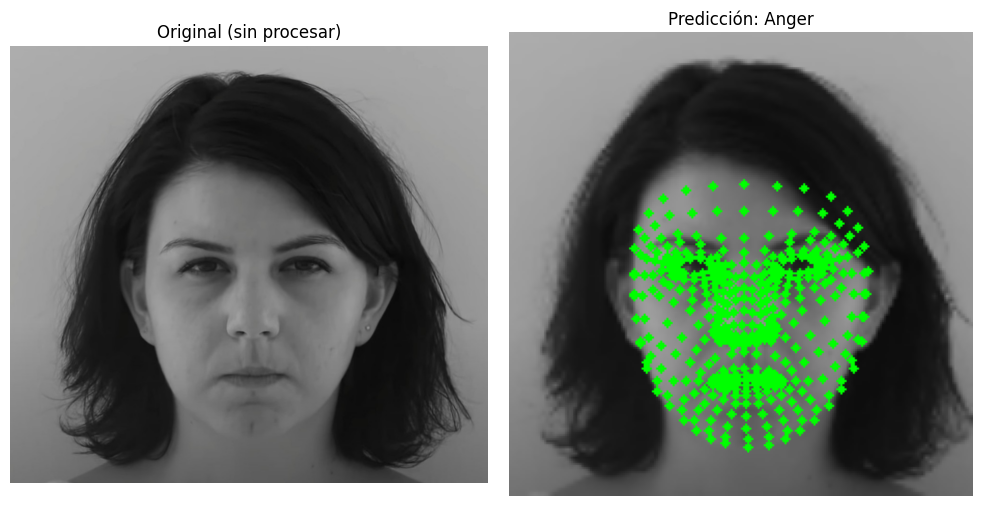

In [ ]:
predecir_emocion("pruebas/p4.jpg") 

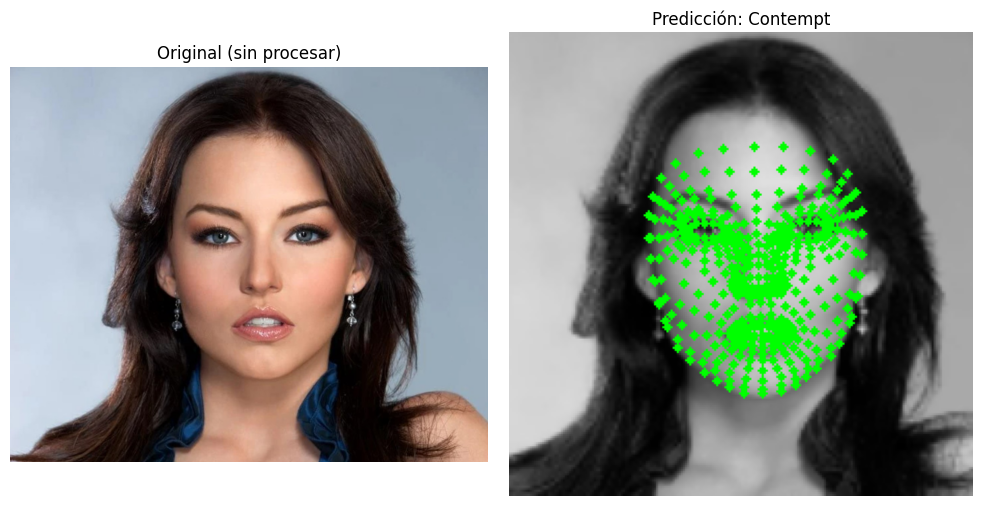

In [ ]:
predecir_emocion("pruebas/p5.jpg") 

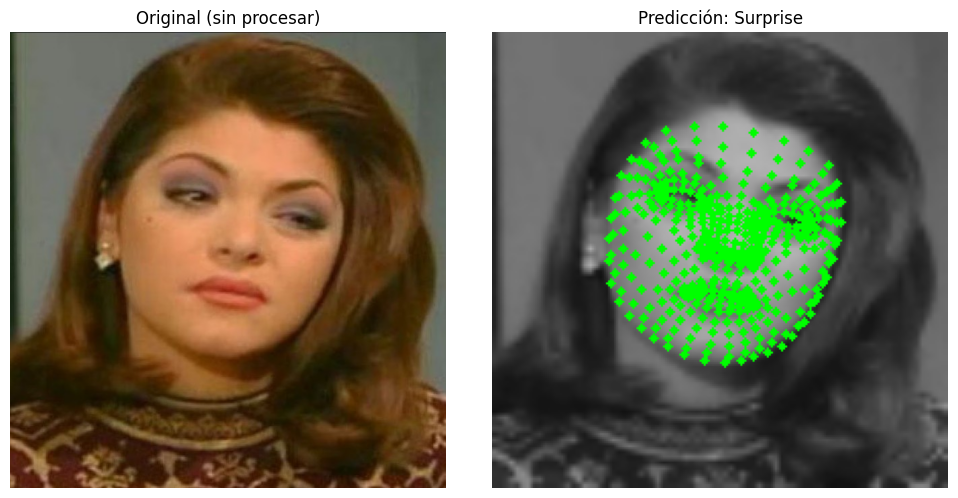

In [ ]:
predecir_emocion("pruebas/p6.jpg") 